In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_file_path = "../data/20250512/processed/ishii0001_ica_epochs.pkl"

In [4]:
# pickleのEEGデータを読み込む
with open(data_file_path, 'rb') as f:
    data = pickle.load(f)

epochs_list = data['epochs_data']  # エポックデータ
labels = data['labels']  # ラベル
drop_indices = data['drop_indices']  # 除外されたエポックのインデックス
fs = data['sfreq']  # サンプリング周波数

In [ ]:
# labelsが9999のものを除外する
valid_indices = np.where(labels != 9999)[0]
epochs_list = epochs_list[valid_indices]
labels = labels[valid_indices]

[   3 9999    3 9999    2 9999    1 9999    2 9999    3 9999    1 9999
    2 9999    1 9999    3 9999    1 9999    4 9999    4 9999    4 9999
    2 9999    2 9999    1 9999    4 9999    4 9999    3 9999]
Valid indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38]


In [6]:
epochs_list.shape

(20, 31, 1501)

In [7]:
labels.shape

(20,)

In [8]:
# 1チャンネルのデータをDFTしてバンドパスパワーを計算
def calc_spectrum(data, band_count, fs):
    n = len(data)
    freq = np.fft.fftfreq(n, 1/fs)
    spectrum = np.fft.fft(data)
    # 1Hz-40Hzまでの4Hzごとのバンドパスパワーを計算
    band_lower = 0
    band_upper = 40
    band_powers = [None] * band_count
    for i in range(band_count):
        band = band_lower+i*(band_upper-band_lower)/band_count, band_lower+(i+1)*(band_upper-band_lower)/band_count
        band_power = np.sum(np.abs(spectrum[(freq >= band[0]) & (freq < band[1])])**2)
        band_powers[i] = band_power
    
    # band_powersの中にNoneがないことをassert
    # assert all([v is not None for v in band_powers]), "Some band powers are None"
    assert all(band_powers), "Some band powers are None"
    return band_powers

In [9]:
e0 = epochs_list[0, :, :]
e0c0 = epochs_list[0, 0, :]
e0c0

array([-6.75198725e-07, -5.51066864e-06, -9.36655055e-06, ...,
       -2.97847574e-06, -1.14345378e-06,  1.65799963e-06], shape=(1501,))

In [10]:
calc_spectrum(e0c0, 20, fs)

[np.float64(1.698048075453929e-05),
 np.float64(7.877033988155454e-06),
 np.float64(5.2932576524111285e-06),
 np.float64(2.3761947246002594e-06),
 np.float64(3.800539931161806e-06),
 np.float64(1.6394351019412506e-06),
 np.float64(2.5023727998355163e-06),
 np.float64(5.085831182453228e-06),
 np.float64(2.6741813460157354e-06),
 np.float64(5.423635540066377e-06),
 np.float64(4.6203661178078e-06),
 np.float64(5.843655717298989e-06),
 np.float64(3.520613772255113e-06),
 np.float64(3.568861191267588e-06),
 np.float64(2.964528786281854e-06),
 np.float64(2.9521685999340664e-06),
 np.float64(2.107630082954637e-06),
 np.float64(3.7938655719430237e-06),
 np.float64(2.2300703046209797e-06),
 np.float64(3.5124327087835145e-06)]

In [11]:
# epochs_list[0]の各チャンネルのDFTを計算
def calc_spectrum_all_channels(epoch, band_count, fs):
    n_channels = epoch.shape[0]
    band_powers = np.zeros((n_channels, band_count))
    for i in range(n_channels):
        band_powers[i] = calc_spectrum(epoch[i, :], band_count, fs)
    return band_powers

In [12]:
calc_spectrum_all_channels(e0, 20, fs)

array([[1.69804808e-05, 7.87703399e-06, 5.29325765e-06, 2.37619472e-06,
        3.80053993e-06, 1.63943510e-06, 2.50237280e-06, 5.08583118e-06,
        2.67418135e-06, 5.42363554e-06, 4.62036612e-06, 5.84365572e-06,
        3.52061377e-06, 3.56886119e-06, 2.96452879e-06, 2.95216860e-06,
        2.10763008e-06, 3.79386557e-06, 2.23007030e-06, 3.51243271e-06],
       [2.38896386e-05, 8.08923336e-06, 5.53178161e-06, 2.37089290e-06,
        3.71408518e-06, 1.35202379e-06, 2.78491095e-06, 4.68570056e-06,
        2.80511817e-06, 5.09029470e-06, 4.73761113e-06, 5.88989171e-06,
        3.63770022e-06, 3.14035211e-06, 2.95727194e-06, 3.24864889e-06,
        1.67995095e-06, 3.61447185e-06, 2.27670030e-06, 3.56422654e-06],
       [1.70832749e-05, 1.03702119e-05, 6.08457997e-06, 3.06895083e-06,
        3.93385422e-06, 1.80844457e-06, 2.57348988e-06, 4.70489660e-06,
        2.81555045e-06, 4.48107102e-06, 4.77298906e-06, 5.28657677e-06,
        3.82235970e-06, 3.02119989e-06, 2.37411805e-06, 3.8114

In [13]:
band_count = 20
all_epochs_band_powers = np.zeros((epochs_list.shape[0], epochs_list.shape[1], 20))
for i in range(epochs_list.shape[0]):
    for j in range(epochs_list.shape[1]):
        all_epochs_band_powers[i] = calc_spectrum_all_channels(epochs_list[i], band_count, fs)

In [14]:
all_epochs_band_powers

array([[[1.69804808e-05, 7.87703399e-06, 5.29325765e-06, ...,
         3.79386557e-06, 2.23007030e-06, 3.51243271e-06],
        [2.38896386e-05, 8.08923336e-06, 5.53178161e-06, ...,
         3.61447185e-06, 2.27670030e-06, 3.56422654e-06],
        [1.70832749e-05, 1.03702119e-05, 6.08457997e-06, ...,
         3.58452191e-06, 2.52307492e-06, 3.29316993e-06],
        ...,
        [2.43857141e-05, 1.08393414e-05, 1.20955712e-05, ...,
         1.25337338e-05, 7.34409567e-06, 4.59228820e-06],
        [1.91033328e-05, 1.85507105e-05, 1.31652032e-05, ...,
         6.32993675e-06, 6.24779863e-06, 6.27901188e-06],
        [1.84833591e-05, 1.42713105e-05, 1.41295730e-05, ...,
         6.61225869e-06, 3.79425248e-06, 3.71322130e-06]],

       [[2.15924772e-05, 6.11178238e-06, 6.36459923e-06, ...,
         1.07719092e-06, 1.70818105e-06, 1.58848987e-06],
        [2.02675579e-05, 6.45784092e-06, 6.55852245e-06, ...,
         1.30285643e-06, 1.91599155e-06, 1.62368528e-06],
        [1.47121946e-05, 

In [15]:
# 特徴量を2次元配列に変換（サンプル数×特徴量）
# 31*20=620の特徴量を持つ40個のデータに変換
X = all_epochs_band_powers.reshape(all_epochs_band_powers.shape[0], -1)
print(f"特徴量のshape: {X.shape}")
print(f"ラベルのshape: {labels.shape}")

特徴量のshape: (20, 620)
ラベルのshape: (20,)


In [16]:
# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=labels)

In [17]:
# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# SVMモデルの作成と学習
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = svm.predict(X_test_scaled)

# 評価
print("分類レポート:")
print(classification_report(y_test, y_pred))# ラベルの分布を確認
unique_labels, counts = np.unique(labels, return_counts=True)
print("ラベルの分布:")
for label, count in zip(unique_labels, counts):
    print(f"ラベル {label}: {count}個")

分類レポート:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.25      1.00      0.40         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1

    accuracy                           0.17         6
   macro avg       0.06      0.25      0.10         6
weighted avg       0.04      0.17      0.07         6

ラベルの分布:
ラベル 1: 5個
ラベル 2: 5個
ラベル 3: 5個
ラベル 4: 5個


/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23455 (\N{CJK UNIFIED IDEOGRAPH-5B9F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/IPython

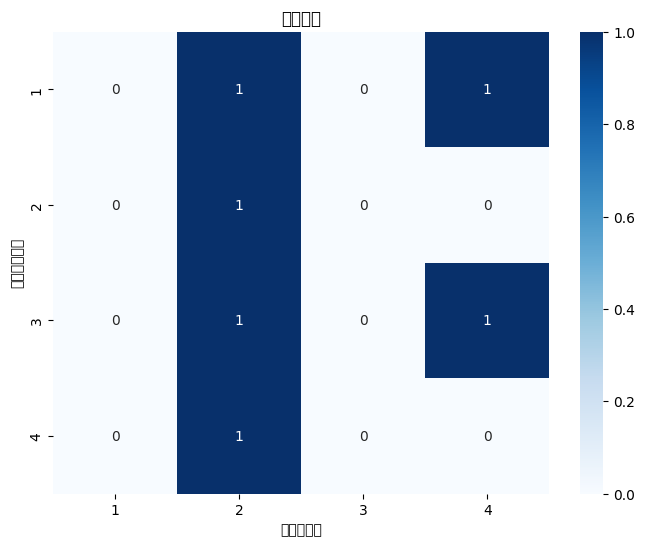

In [19]:
# 混同行列の表示
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=unique_labels, 
           yticklabels=unique_labels)
plt.xlabel('予測ラベル')
plt.ylabel('実際のラベル')
plt.title('混同行列')
plt.show()

In [20]:
# クロスバリデーションで評価
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5)
print(f"クロスバリデーションスコア: {cv_scores}")
print(f"平均精度: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [ ]:
# ハイパーパラメータチューニング
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"最適パラメータ: {grid_search.best_params_}")
print(f"最高スコア: {grid_search.best_score_:.4f}")

In [ ]:
# 最適なモデルで評価
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)

print("最適モデルの分類レポート:")
print(classification_report(y_test, y_pred_best))

# 混同行列の表示
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
           xticklabels=unique_labels, 
           yticklabels=unique_labels)
plt.xlabel('予測ラベル')
plt.ylabel('実際のラベル')
plt.title('最適モデルの混同行列')
plt.show()